In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/kaggle/input/player-teams-classification/dataset_pemain"
image_size = 128
batch_size = 64
num_epochs = 10
patience = 8

In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    
    # Rotasi ekstrim dan mirror
    transforms.RandomHorizontalFlip(p=1.5),
    transforms.RandomVerticalFlip(p=0.8),
    transforms.RandomRotation(degrees=80),
    
    # Distorsi geometris dan skala ekstrem
    transforms.RandomAffine(
        degrees=60,
        translate=(0.3, 0.3),
        scale=(0.5, 1.5),
        shear=45
    ),
    
    # Warna benar-benar diacak
    transforms.ColorJitter(
        brightness=0.8,
        contrast=0.8,
        saturation=0.8,
        hue=0.3
    ),
    
    # Blur dan noise
    transforms.GaussianBlur(kernel_size=(7, 7), sigma=(2.0, 5.0)),
    transforms.RandomGrayscale(p=1.0),
    
    # Konversi ke tensor dan normalisasi
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [4]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Tentukan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s] 


In [5]:
print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 982
Val samples: 122
Test samples: 124


In [15]:
data = []
for file_path, label in dataset.samples:
    data.append([file_path, class_names[label]])

df = pd.DataFrame(data, columns=["file", "label"])
df.head()

,file,label
0,/kaggle/input/player-teams-classification/data...,barca
1,/kaggle/input/player-teams-classification/data...,barca
2,/kaggle/input/player-teams-classification/data...,barca
3,/kaggle/input/player-teams-classification/data...,barca
4,/kaggle/input/player-teams-classification/data...,barca


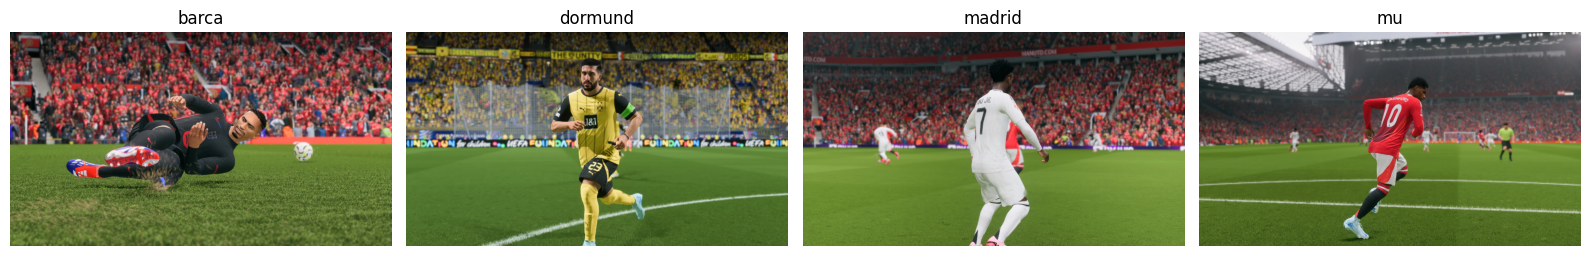

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(df['label'].unique()):
    sample_path = df[df['label'] == label].sample(1)['file'].values[0]
    img = Image.open(sample_path)
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [6]:
import time

best_val_loss = float('inf')
patience_counter = 0

train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()

    # Training
    model.train()
    train_loss, train_correct = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_acc = train_correct / len(train_dataset)
    train_loss_avg = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_acc = val_correct / len(val_dataset)
    val_loss_avg = val_loss / len(val_loader)

    # Logging
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss_avg)
    val_loss_history.append(val_loss_avg)

    elapsed_time = time.time() - start_time
    epoch_times.append(elapsed_time)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f} | "
          f"Time: {elapsed_time:.2f}s")

    # Early stopping
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        patience_counter = 0
        print("✅ Validation loss improved.")
    else:
        patience_counter += 1
        print(f"⚠️No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⛔ Early stopping triggered!")
            break

# Setelah loop selesai
avg_epoch_time = sum(epoch_times) / len(epoch_times)
print(f"\n📊 Rata-rata waktu per epoch: {avg_epoch_time:.2f} detik")


Epoch 1/10 | Train Acc: 0.2943 | Val Acc: 0.2377 | Train Loss: 1.9257 | Val Loss: 357.7182 | Time: 87.56s
✅ Validation loss improved.
Epoch 2/10 | Train Acc: 0.2790 | Val Acc: 0.2459 | Train Loss: 1.4224 | Val Loss: 6.4816 | Time: 78.57s
✅ Validation loss improved.
Epoch 3/10 | Train Acc: 0.2963 | Val Acc: 0.3115 | Train Loss: 1.3628 | Val Loss: 1.3705 | Time: 78.41s
✅ Validation loss improved.
Epoch 4/10 | Train Acc: 0.2994 | Val Acc: 0.2131 | Train Loss: 1.3695 | Val Loss: 2.0996 | Time: 79.77s
⚠️No improvement. Patience: 1/8
Epoch 5/10 | Train Acc: 0.3136 | Val Acc: 0.2787 | Train Loss: 1.3732 | Val Loss: 1.3834 | Time: 78.92s
⚠️No improvement. Patience: 2/8
Epoch 6/10 | Train Acc: 0.2811 | Val Acc: 0.2869 | Train Loss: 1.4355 | Val Loss: 1.7821 | Time: 79.53s
⚠️No improvement. Patience: 3/8
Epoch 7/10 | Train Acc: 0.2933 | Val Acc: 0.3443 | Train Loss: 1.3798 | Val Loss: 2.0807 | Time: 79.11s
⚠️No improvement. Patience: 4/8
Epoch 8/10 | Train Acc: 0.2943 | Val Acc: 0.2459 | Train L

In [7]:
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       barca       0.00      0.00      0.00        33
     dormund       0.29      0.82      0.43        33
      madrid       0.52      0.44      0.48        36
          mu       0.00      0.00      0.00        22

    accuracy                           0.35       124
   macro avg       0.20      0.32      0.23       124
weighted avg       0.23      0.35      0.25       124



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


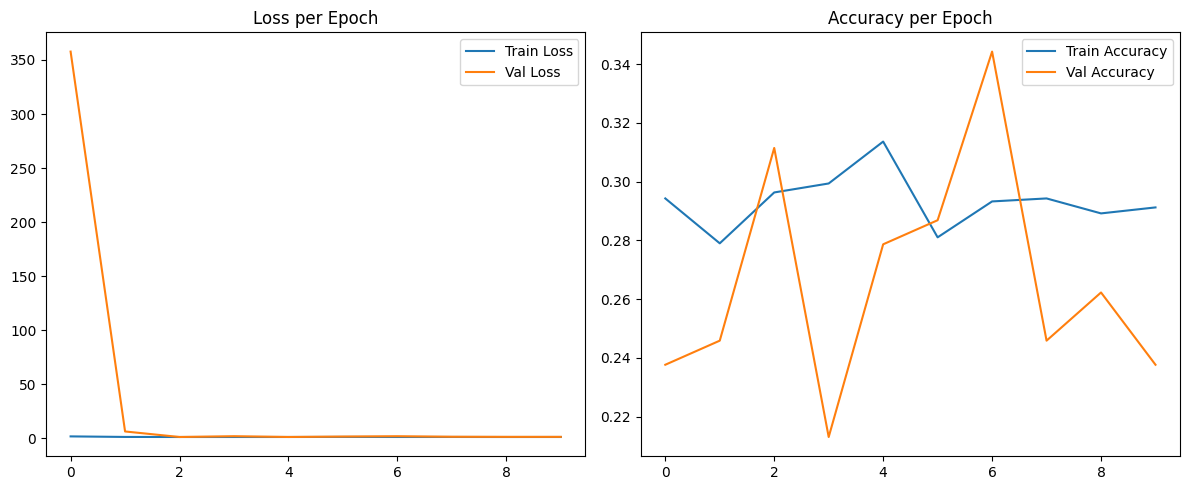

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

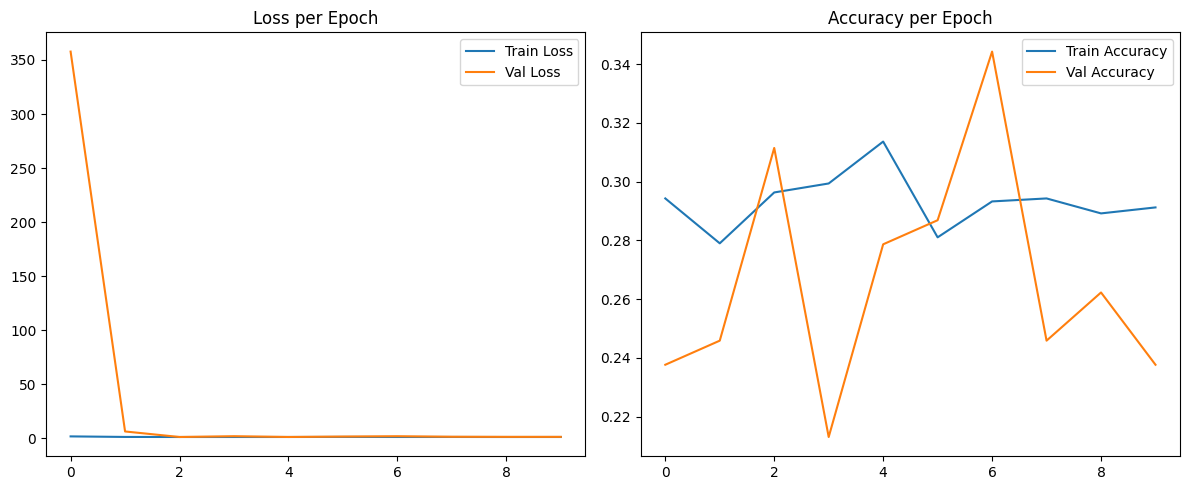

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.tight_layout()
plt.show()

In [10]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Pastikan model dalam mode evaluasi
model.eval()

# Untuk menyimpan hasil
y_true = []
y_pred = []

# Jangan hitung gradien saat evaluasi (hemat memori dan lebih cepat)
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Hitung akurasi
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Akurasi pada test set: {accuracy:.4f}")


Akurasi pada test set: 0.3548


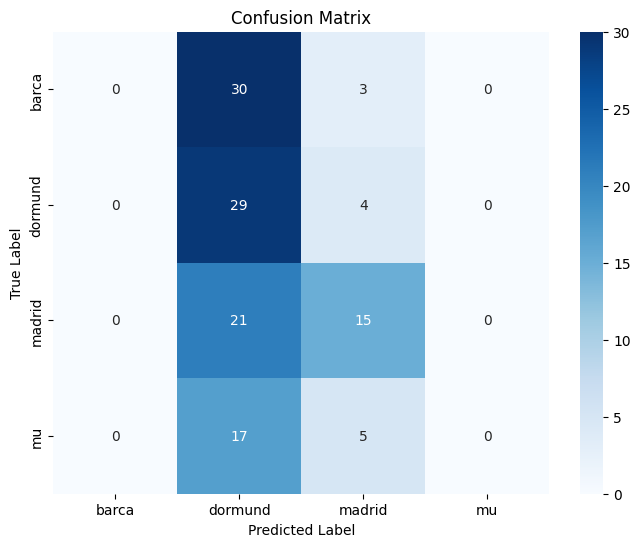

Classification Report:
              precision    recall  f1-score   support

       barca       0.00      0.00      0.00        33
     dormund       0.30      0.88      0.45        33
      madrid       0.56      0.42      0.48        36
          mu       0.00      0.00      0.00        22

    accuracy                           0.35       124
   macro avg       0.21      0.32      0.23       124
weighted avg       0.24      0.35      0.26       124



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [20]:
import torch
from torchvision import models, transforms
from PIL import Image
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Fungsi untuk melakukan prediksi dan menampilkan hasilnya di console
def predict_image(image_data, transform, model, class_names):
    img = Image.open(BytesIO(image_data)).convert('RGB')
    
    # Preprocessing gambar
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Melakukan prediksi
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = class_names[predicted_idx.item()]
        
        # Menampilkan gambar dan hasil prediksi di console
        print(f"Predicted class: {predicted_class}")
        
        # Menampilkan gambar
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis('off')
        plt.show()

# Widget untuk upload file gambar
def upload_and_predict(class_names):
    upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
    display(upload_widget)

    def on_upload_change(change):
        uploaded_image = upload_widget.value[0]
        image_data = uploaded_image['content']
        predict_image(image_data, transform, model, class_names)

    upload_widget.observe(on_upload_change, names='value')

# Memulai session upload dan prediksi
upload_and_predict(class_names)

FileUpload(value=(), accept='image/*', description='Upload')